# *COVID-19 Community Mobility Reports:​ Regression*

### Authors:
- Ana Mafalda Santos, up201706791
- Diogo Silva, up201706892
- João Luz, up201703782

## Introduction
---
The main purpose of this project was to build a regression model using different **Supervised Learning** algorithms for the given dataset: **CoV-19 Community Mobility Report**.

After analyzing and handling our dataset, we aim to predict the number of people infected and the number of deaths caused by SARS-CoV-2 based on the variation of the population's mobility trends and some other factors. To make it less biased, we'll predict the confirmed cases and the number of deaths per million instead of using just the total amounts, as different countries have different population sizes.

## Description of the Problem/Dataset
---
Our dataset - **CoV-19 Community Mobility Report** - seeks to provide insights into what has changed due to policies aimed at combating COVID-19 and evaluate the changes in community activities and its relation to reduced confirmed cases of COVID-19. The reports chart movement trends, comparing to an expected baseline, over time by geography, across the following categories of places:

* **Retail & Recreation**: Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.
* **Grocery & Pharmacy**: Mobility trends for places like grocery markets, food warehouses, farmers' markets, specialty food shops, drug stores, and pharmacies.
* **Parks**: Mobility trends for places like national parks, public beaches, marinas, dog parks, plazas, and public gardens.
* **Transit stations**: Mobility trends for places like public transport hubs such as subway, bus, and train stations.
* **Workplaces**: Mobility trends for places of work.
* **Residential**: Mobility trends for places of residence.

The dataset also contains these CoV-19 statistics:

* **Total Cases**: Total number of people infected with the SARS-CoV-2.
* **Fatalities**: Total number of deaths caused by CoV-19.
* **Population**: Total number of inhabitants.
* **GDP per Capita (PPP)**: Gross Domestic Product (GDP) per capita based on Purchasing Power Parity (PPP), taking into account the relative cost of local goods, services and inflation rates of the country, rather than using international market exchange rates, which may distort the real differences in per capita income.
* **Health System Index**: Overall performance of the health system.
* **Human Development Index (HDI)**: Summary index based on life expectancy at birth, expected years of schooling for children and mean years of schooling for adults, and GNI per capita.
* **Government Response Stringency Index**: Additive score of nine indicators of government response to CoV-19: School closures, workplace closures, cancellation of public events, public information campaigns, stay at home policies, restrictions on internal movement, international travel controls, testing policy, and contact tracing.
* **Elderly Population (percentage)**: Percentage of the population above the age of 65 years old.

## Approach
---
We start by pre-processing the data we had. To compensate for missing and NaN values on the dataset, we used Median and Zero Imputation, to better infer those missing values from the existing part of the data. We also added new columns to extract more information from the existing columns:

* **New Cases (percentage)**: variation of the total cases of CoV-19 cases in comparison to the previous day.
* **New Fatalities (percentage)**: variation of the total fatalities of CoV-19 cases in comparison to the previous day.
* **Cases per Million**: total cases CoV-19 cases per million people.
* **Deaths per Million**: total CoV-19 deaths per million people.
* **Fatality Rate**: proportion of deaths from CoV-19 compared to the total number of confirmed CoV-19 cases.

The incubation period for COVID-19 (time between the exposure to the virus, becoming infected and symptoms onset) is on average 5-6 days, even though it can take up to 14 days. This means features such as the mobility changes and government-imposed policies (represented by the Stringency Index) are not immediately reflected in the evolution of the disease. Therefore, it makes sense to replace such features by the 7-10 previous days values when predicting a certain day.

In order to train and test the model, we partitioned the input data into training and testing data using the Train/Test Split.

To predict the number of people infected based on the available data, we used different algorithms with tweaked parameters for our regression model: **Support Vector Regression (SVR)**, **K-Nearest Neighbors**, **Decision Trees** and **Neural Networks (Multi-layer Perceptron)**.

After making the desired predictions, a limited sample of data is used in order to estimate how the models are expected to perform in general when used to make predictions on data not used during the training of these models.

At last, to reduce the dimension of our dataset by using Principal Component Analysis (PCA) which combines highly correlated variables together to form a smaller number of an artificial set of variables that account for the most variance in the data.

## Experimental Evaluation
---
In this section, we will try to provide a step-by-step explanation of our approach and show the way different factors shaped our implementation along the way. 

Starting with the necessary imports:

In [1]:
import math
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_validate, train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn import preprocessing, linear_model, neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from matplotlib import style
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
# Reads CVS file to Data Frame
data = pd.read_csv('Global_Mobility_Report.csv')

### A First Look At The Dataset

In the following graph, we can see how the mobility (in this case retail and recreation) varies once the number of cases starts to increase. The mobility along with other factors mentioned, will be used to predict the evolution of the number of cases.

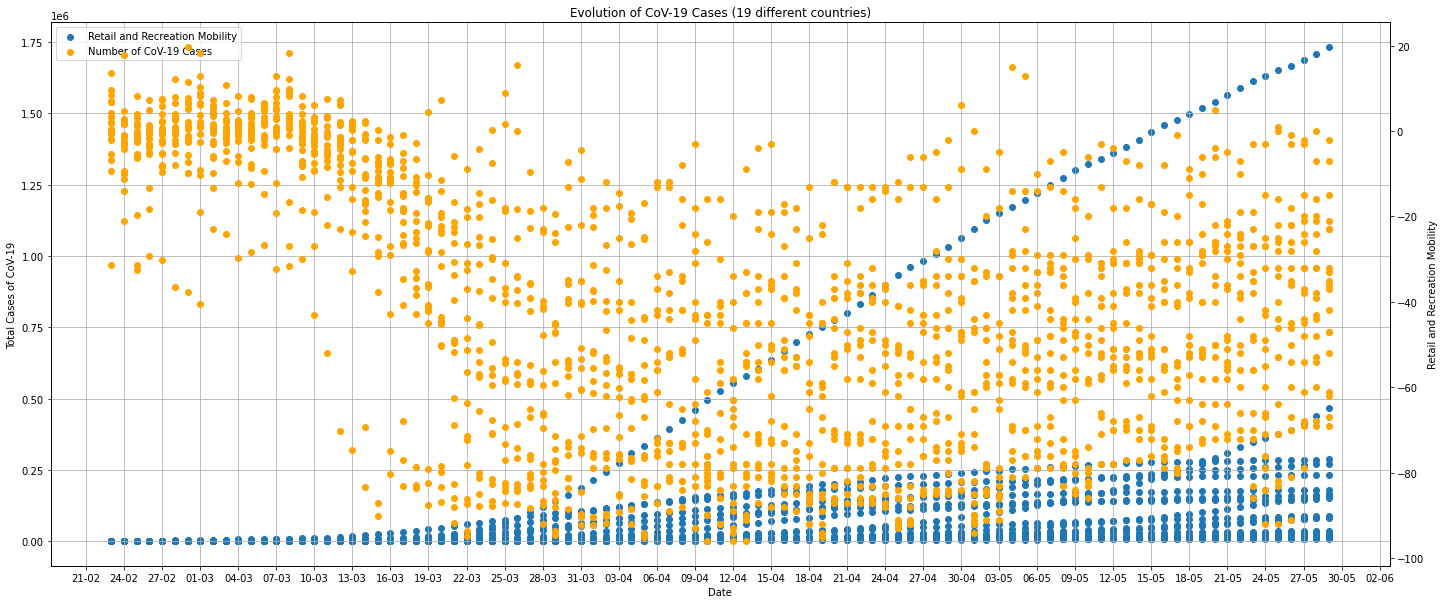

In [3]:
dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
cases_scatter1 = ax.scatter(date_format, data['total_cases'])
ax.set(xlabel="Date", ylabel='Total Cases of CoV-19', title=("Evolution of CoV-19 Cases (19 different countries)"))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.tick_params(axis='y')
ax2 = ax.twinx()  
ax2.set_ylabel('Retail and Recreation Mobility')
retail_scatter1 = ax2.scatter(date_format, data['retail_recreation'], color = "orange")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax2.tick_params(axis='y')
ax.legend((cases_scatter1,retail_scatter1), ('Retail and Recreation Mobility', 'Number of CoV-19 Cases'), loc='upper left', shadow=False)
plt.show()

In [4]:
# If we were taking the country column into account,
# it would intersting to take care of the Dummy Variable Trap.
# Alternatively, we chose to eliminate these columns completely.
print(data.head(100))
data = data.drop(columns = ['country','iso'])

iso       country       date  grocery_pharmacy   parks  residential  \
0   IN         India  2/23/2020            -1.192   0.717        0.969   
1   IN         India  2/24/2020             0.036   2.103        0.189   
2   IN         India  2/25/2020            -1.737   2.650        0.128   
3   IN         India  2/26/2020            -0.197   1.497       -0.683   
4   IN         India  2/27/2020            -0.699   3.362       -0.205   
..  ..           ...        ...               ...     ...          ...   
95  IN         India  5/28/2020           -14.000 -54.000       19.000   
96  IN         India  5/29/2020           -10.000 -54.000       19.000   
97  ZA  South Africa  2/23/2020            -6.354 -20.793        2.833   
98  ZA  South Africa  2/24/2020           -13.296 -10.143        0.614   
99  ZA  South Africa  2/25/2020            -1.495  -4.721       -0.822   

    retail_recreation  transit_stations  workplaces  total_cases  fatalities  \
0              -2.077            -

### Extraction of new relevant columns

As mentioned before, we will be taking into account both the measures taken 7 and 10 days prior to each day of the dataset.

In [5]:
data['fatalities_per_million'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    millions = data['population'][i]/1000000
    data['fatalities_per_million'][i]= data['fatalities'][i]/millions

data['fatalities_rate'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    if data['total_cases'][i] != 0:
        data['fatalities_rate'][i]= data['fatalities'][i] * 100 /data['total_cases'][i]
    else:
        data['fatalities_rate'][i] = 0

# Calculates daily percentual changes in number of fatalities
# data['cases_per_million'] = pd.Series([])
data.insert(13, "cases_per_million", 0) 
for i in range(0,len(data['total_cases'])):
    millions = data['population'][i]/1000000
    data['cases_per_million'][i]= data['total_cases'][i]/millions

column_names = ['date', 'grocery_pharmacy', 'parks', 'residential', 'retail_recreation',
       'transit_stations', 'workplaces','fatalities_rate','response_stringency_index','cases_per_million', 'fatalities_per_million','population']
# print(data.columns)
nentries= 97
for i in range(1, len(column_names) - 1):
    data[column_names[i] + '_previous_week'] = pd.Series([])
    data[column_names[i] + '_prev_10_days'] = pd.Series([])
    for j in range(0,len(data)):
            index = j % nentries
            if index >= 7:
                data[column_names[i] + '_previous_week'][j]= data[column_names[i]][j-7]
                if index >= 10:
                    data[column_names[i] + '_prev_10_days'][j] = data[column_names[i]][j-10]
                else:
                    data[column_names[i] + '_prev_10_days'][j] = 0
            else:
                data[column_names[i] + '_previous_week'][j]= 0
                data[column_names[i] + '_prev_10_days'][j] = 0
    if (i < len(column_names)-3):
        data = data.drop(columns = [column_names[i]])

data = data.drop(columns = ['total_cases'])
data = data.drop(columns = ['fatalities'])

column_order = ['date', 'grocery_pharmacy_previous_week', 'parks_previous_week', 'residential_previous_week', 'retail_recreation_previous_week',
       'transit_stations_previous_week', 'workplaces_previous_week', 'cases_per_million_previous_week','fatalities_per_million_previous_week', 'fatalities_rate_previous_week','gdp_ppp','health_system_index', 'human_development_index', 'response_stringency_index_previous_week', 'grocery_pharmacy_prev_10_days', 'parks_prev_10_days', 'residential_prev_10_days', 'retail_recreation_prev_10_days', 'transit_stations_prev_10_days', 'workplaces_prev_10_days', 'cases_per_million_prev_10_days','fatalities_per_million_prev_10_days', 'fatalities_rate_prev_10_days','response_stringency_index_prev_10_days','age_above_65_percentage', 'cases_per_million','fatalities_per_million']
data = data[column_order]

data.head(45)

,date,grocery_pharmacy_previous_week,parks_previous_week,residential_previous_week,retail_recreation_previous_week,transit_stations_previous_week,workplaces_previous_week,cases_per_million_previous_week,fatalities_per_million_previous_week,fatalities_rate_previous_week,...,retail_recreation_prev_10_days,transit_stations_prev_10_days,workplaces_prev_10_days,cases_per_million_prev_10_days,fatalities_per_million_prev_10_days,fatalities_rate_prev_10_days,response_stringency_index_prev_10_days,age_above_65_percentage,cases_per_million,fatalities_per_million
0,2/23/2020,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
1,2/24/2020,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
2,2/25/2020,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
3,2/26/2020,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
4,2/27/2020,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
5,2/28/2020,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
6,2/29/2020,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
7,3/1/2020,-1.192,0.717,0.969,-2.077,-0.484,2.213,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
8,3/2/2020,0.036,2.103,0.189,-1.264,0.882,4.271,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000
9,3/3/2020,-1.737,2.650,0.128,-0.691,1.087,1.055,0.0,0.000000,0.000000,...,0.000,0.000,0.000,0.0,0.000000,0.000000,0.0000,6.0,0,0.000000


We will start by using data from every coutry in the dataset to predict the number of cases of SARS-CoV-2 per million in Italy. First, need to define the Total Number of Cases per Million as our **target variable** and isolate it from our **independent variables**. After that, we can start pre-processing our data so it is ready to be used by our models. 

In [6]:
X = data.iloc[:,1:25]
Y = data.iloc[:,25:26]
X

,grocery_pharmacy_previous_week,parks_previous_week,residential_previous_week,retail_recreation_previous_week,transit_stations_previous_week,workplaces_previous_week,cases_per_million_previous_week,fatalities_per_million_previous_week,fatalities_rate_previous_week,gdp_ppp,...,parks_prev_10_days,residential_prev_10_days,retail_recreation_prev_10_days,transit_stations_prev_10_days,workplaces_prev_10_days,cases_per_million_prev_10_days,fatalities_per_million_prev_10_days,fatalities_rate_prev_10_days,response_stringency_index_prev_10_days,age_above_65_percentage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,6.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,-8.0,2.0,15.0,-26.0,-43.0,-40.0,4553.0,255.970769,5.621906,67426,...,21.0,16.0,-29.0,-40.0,-42.0,4354.0,247.437499,5.682396,0.7269,15.4
1839,-4.0,15.0,15.0,-24.0,-40.0,-41.0,4612.0,260.301222,5.642963,67426,...,32.0,9.0,-30.0,-34.0,-24.0,4428.0,251.178402,5.671231,0.7269,15.4
1840,-3.0,23.0,15.0,-22.0,-38.0,-41.0,4680.0,264.944683,5.660218,67426,...,17.0,8.0,-30.0,-39.0,-25.0,4488.0,253.563950,5.648621,0.7269,15.4
1841,-1.0,31.0,15.0,-22.0,-37.0,-41.0,4756.0,268.852726,5.651912,67426,...,2.0,15.0,-26.0,-43.0,-40.0,4553.0,255.970769,5.621906,0.7269,15.4


In [7]:
# Fills the empty values taking mean values present in each column (Mean Inputation)
X = X.replace("", np.NaN)
Y = Y.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = imputer.fit_transform(X)
Y = imputer.fit_transform(Y)

# print(Y)

To prevent a feature that has a variance that is orders of magnitude larger than others, from dominating the objective function and make the estimator unable to learn from other features correctly as expected, it is wise to perform standardization of such features.

In [8]:
# Standardization using Gaussian Normal Distribution
X = preprocessing.scale(X)

Once pre-processed, our data can now be divided into subsets meant for training and testing our models. We decided to apply Train/Test Split (70%/30%) which randomly selects the input and output data as training or testing data.

In [9]:
# Create training and testing vars
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

We are now ready to start training and testing our models.

### Support Vector Regression

We start by using the SVR algorithm, which is an extension of the Support Vector Machine algorithm, usually used in Classification models, but applied to Regression. The **scikit-learn** library provides several alternatives for kernel functions, namely **Radial Basis** (the default option according to the documentation), **Linear**, or **Polynomial**. Besides being relatively memory efficient, the SVR algorithm works well with high dimensional spaces and datasets without too much noise. Making it a good contender for this problem.
In this section, we will be comparing the performance of these kernels to the **Ordinary Least Squares Linear Regression** (OLS). 

In [10]:
# Linear Regression Model
lm = linear_model.LinearRegression()

# Suport Vector Regression Models
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

# Fitting/Training models
model = lm.fit(X_train, Y_train)
svr_lin_model = svr_lin.fit(X_train, Y_train)
svr_rbf_model = svr_rbf.fit(X_train, Y_train)
svr_poly_model = svr_poly.fit(X_train, Y_train)

# Obtaining predictions from models
X_pred = X[1067:1163,:]
Y_pred_label = Y[1067:1163,:]

linear_predictions = lm.predict(X_pred)
svr_lin_predictions = svr_lin_model.predict(X_pred)
svr_rbf_predictions = svr_rbf_model.predict(X_pred)
svr_poly_predictions = svr_poly_model.predict(X_pred)

# Testing models
linear_score = model.score(X_test, Y_test)
svr_lin_score = svr_lin_model.score(X_test, Y_test)
svr_rbf_score = svr_rbf_model.score(X_test, Y_test)
svr_poly_score = svr_poly_model.score(X_test, Y_test)

print("Linear Regression Score:", linear_score)
print("Linear SVR Score: %s" % (svr_lin_score))
print("RBF SVR Score: %s" % (svr_rbf_score))
print("Polynomial SVR Score: %s" % (svr_poly_score))

# Evaluating the models
linear_eval = cross_val_score(model, X, Y, cv=10)
svr_lin_eval = cross_val_score(svr_lin, X, Y, cv=10)
svr_rbf_eval = cross_val_score(svr_rbf, X, Y, cv=10)
svr_poly_eval = cross_val_score(svr_poly, X, Y, cv=10)

print("\nLinear Regression CV:", np.mean(linear_eval))
print("Linear SVR CV: %s" % (np.mean(svr_lin_eval)))
print("RBF SVR CV: %s" % (np.mean (svr_rbf_eval)))
print("Polynomial SVR CV: %s" % (np.mean(svr_poly_eval)))

Linear Regression Score: 0.9979494304375061
Linear SVR Score: 0.9947908879500098
RBF SVR Score: 0.933775210401122
Polynomial SVR Score: 0.9955054633947337

Linear Regression CV: 0.9352300773824235
Linear SVR CV: 0.8559185630824956
RBF SVR CV: -6.914304568700567
Polynomial SVR CV: 0.3800585713300326


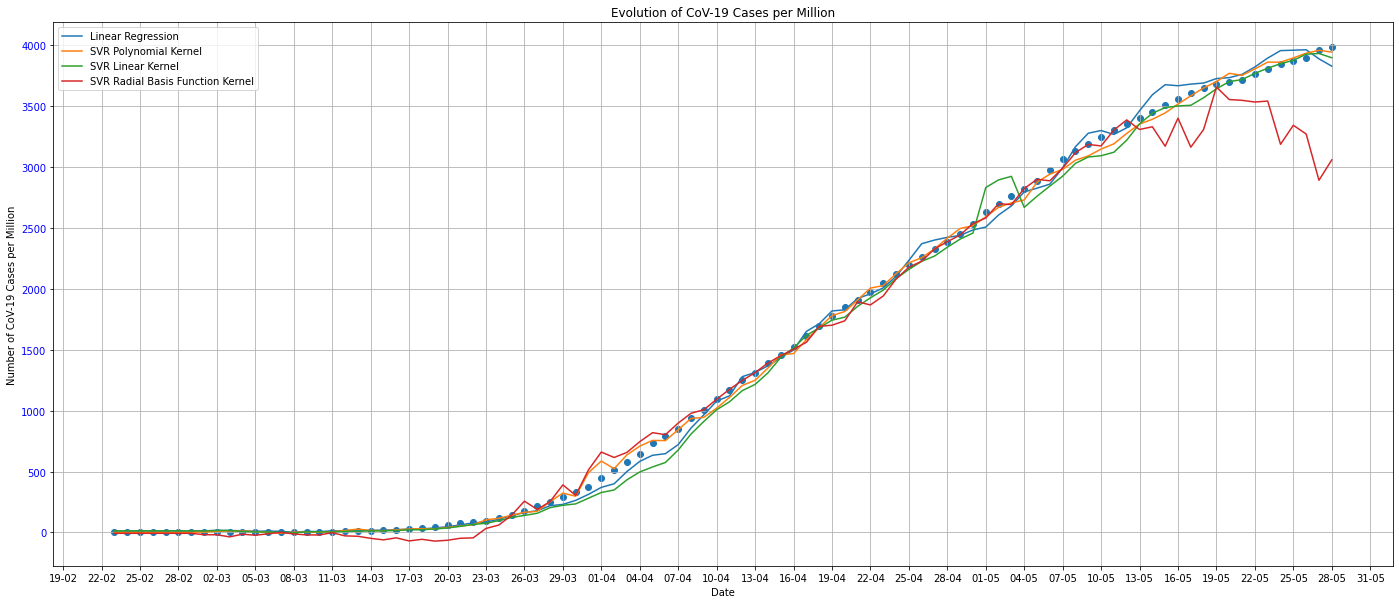

In [11]:
# Visual Comparison of the predictions obtained by different 
# parameterizations of the SVR model compared to a Linear Regression model
dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.scatter(date_format[0:96], Y_pred_label)
linear_plot, = ax.plot(date_format[0:96], linear_predictions)
svr_poly_plot, = ax.plot(date_format[0:96], svr_poly_predictions)
svr_lin_plot, = ax.plot(date_format[0:96], svr_lin_predictions)
svr_rbf_plot, = ax.plot(date_format[0:96], svr_rbf_predictions)
ax.legend((linear_plot, svr_poly_plot, svr_lin_plot, svr_rbf_plot), ('Linear Regression', 'SVR Polynomial Kernel','SVR Linear Kernel', 'SVR Radial Basis Function Kernel'), loc='upper left', shadow=False)

ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title=("Evolution of CoV-19 Cases per Million"))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.tick_params(axis='y', labelcolor= "blue")

As we can see by the scores obtained by the comparison of the predictions with the labeled data in several experiments, the performance of the SVR algorithms tends to be better with the exception of the Radial Basis kernel, which is slightly less accurate.
### K-Nearest Neighbor

We proceed to apply the K-Nearest Neighbor algorithm. Once again, we are given two alternatives for the weights specified for the "neighbors". Using a uniform weight distribution, each of the k-neighbor's weight is taken into account equally. On the other hand, when considering the distance between these neighbors, the weight decreases with the distance.

KNN Regression Model - Uniform:  0.9917764223373067
KNN Regression Model - Distance:  0.9928581307644214

KNN Regression Model - Uniform CV: -0.7866985402520565
KNN Regression Model - Uniform CV: -0.7772326125497141


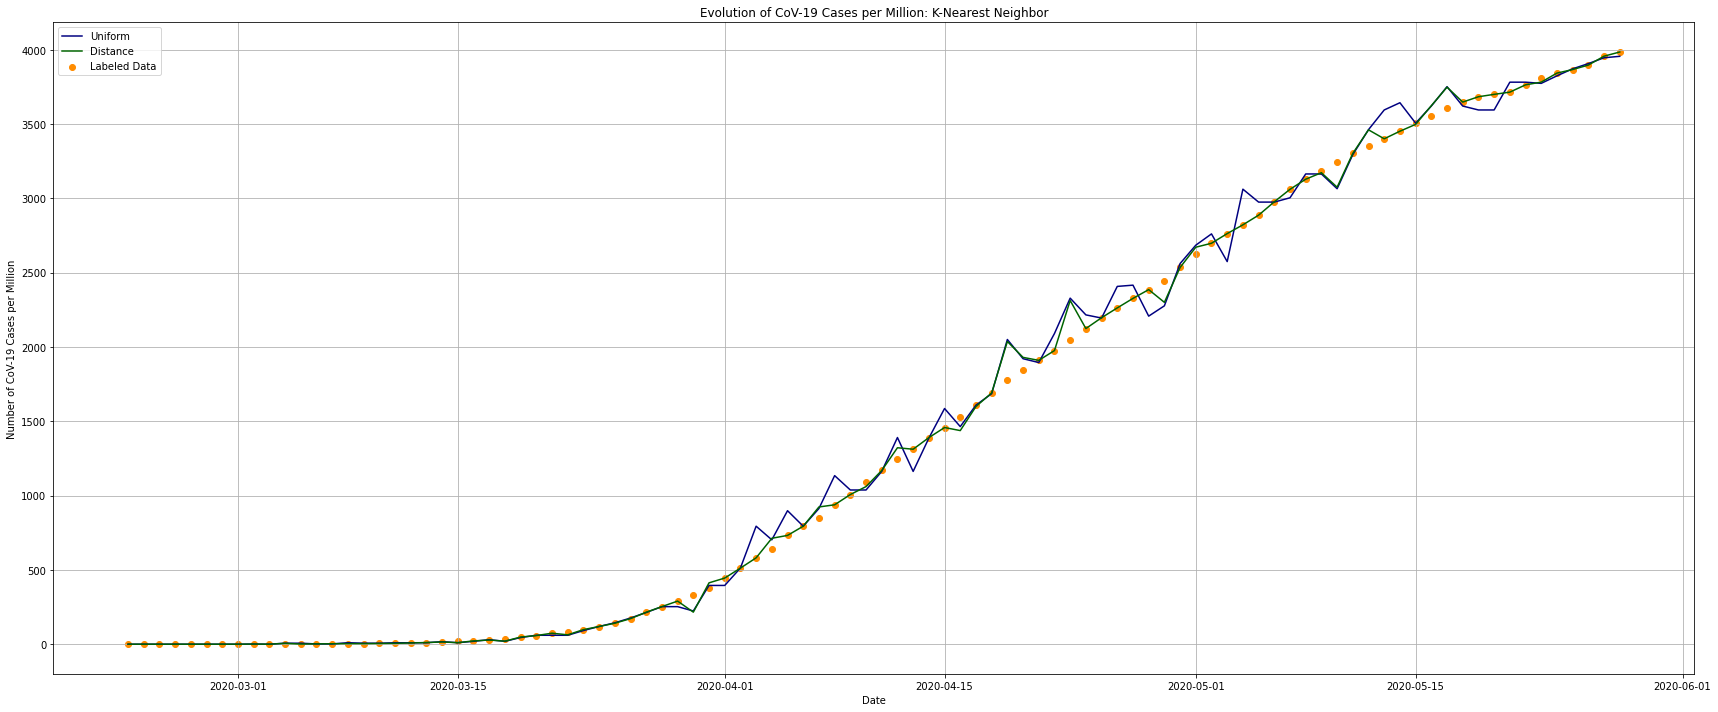

In [12]:
n_neighbors = 3

# K-Nearest Neighbor Models
knn_uniform = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
knn_distance = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')

# Fitting/Training and obtaining predictions from models
knn_predictions_uniform = knn_uniform.fit(X_train, Y_train).predict(X_pred)
knn_predictions_distance = knn_distance.fit(X_train, Y_train).predict(X_pred)

# Testing models
knn_uniform_score = knn_uniform.score(X_test, Y_test)
knn_distance_score = knn_distance.score(X_test, Y_test)

print("KNN Regression Model - Uniform:  %s"  % (knn_uniform_score))
print("KNN Regression Model - Distance:  %s"  % (knn_distance_score))

# Evaluating the models
uniform_eval = cross_val_score(knn_uniform, X, Y, cv=10)
distance_eval = cross_val_score(knn_distance, X, Y, cv=10)

print("\nKNN Regression Model - Uniform CV:", np.mean(uniform_eval))
print("KNN Regression Model - Uniform CV: %s" % (np.mean(distance_eval)))

# Visual Comparison of the predictions obtained by different 
# parameterizations of the KNN model
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[0:96], Y_pred_label, color='darkorange', label='data')
unif, = ax.plot(date_format[0:96], knn_predictions_uniform, color='navy')
dist, = ax.plot(date_format[0:96], knn_predictions_distance, color='darkgreen')
ax.legend((unif, dist, labeled), ('Uniform', 'Distance','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title = "Evolution of CoV-19 Cases per Million: K-Nearest Neighbor")
ax.axis('tight')
plt.tight_layout()
plt.show()

The results obtained with the parameterizations of this algorithm were very promising, with a slight advantage for the distance-based approach. However, according to the Cross Validation results, it doesn't seem to be the most adequate of the algorithms.

### Decision Tree Regression

Another worthy approach for this regression problem is the Decision Tree algorithm. It's important to observe the influence of the *max_depth* parameter of the model to see how it affects its performance. With that in mind, we chose to compare two DT models with *max_depth* values of 5 and 10.

Usually, it would be risky to use a high value for the *max_depth* parameter of a decision tree since it can lead to the model learning from noise present in the data and be prone to **overfit**. 

DT5 0.9886262023570297
DT10 0.995054211341978

DT5 Regression Model CV: 0.8075855905519778
DT10 Regression Model CV: 0.6761809315858694


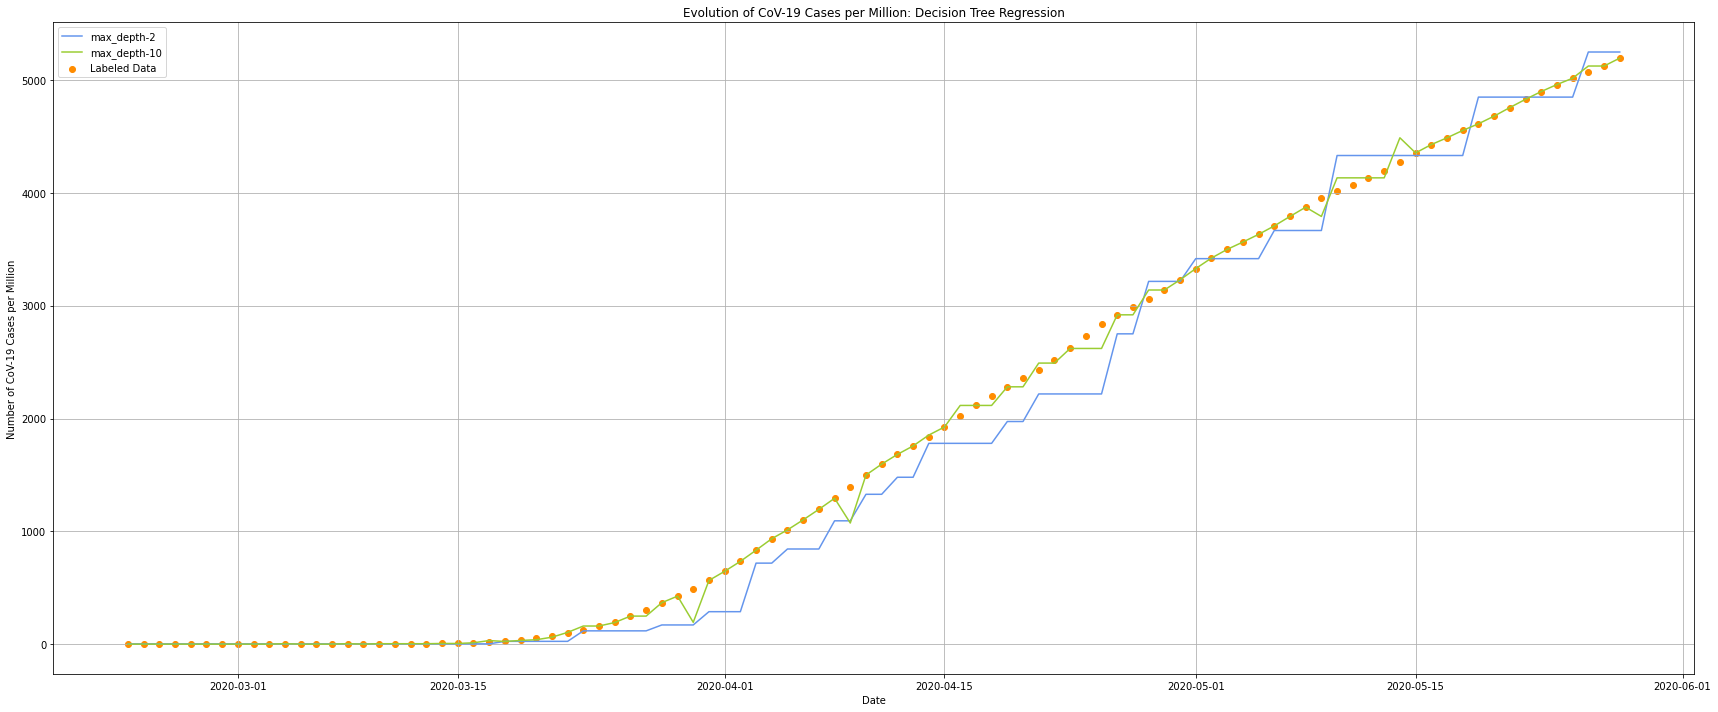

In [13]:
# Decision Tree Models
dt_regressor_5 = DecisionTreeRegressor(max_depth=5)
dt_regressor_10 = DecisionTreeRegressor(max_depth=10)

# Fitting/Training models
dt_regressor_5.fit(X_train, Y_train)
dt_regressor_10.fit(X_train, Y_train)

# Obtaining predictions from models
X_pred = X[1746:1842,:]
Y_pred_label = Y[1746:1842,:]
max_depth5_prediction = dt_regressor_5.predict(X_pred)
max_depth10_prediction = dt_regressor_10.predict(X_pred)

# Testing models
dt_regressor_5_score = dt_regressor_5.score(X_test,Y_test)
dt_regressor_10_score = dt_regressor_10.score(X_test,Y_test)

print("DT5", dt_regressor_5_score)
print("DT10", dt_regressor_10_score)

# Evaluating the models
dt_regressor_5_eval = cross_val_score(dt_regressor_5, X, Y, cv=10)
dt_regressor_10_eval = cross_val_score(dt_regressor_10, X, Y, cv=10)

print("\nDT5 Regression Model CV:", np.mean(dt_regressor_5_eval))
print("DT10 Regression Model CV: %s" % (np.mean(dt_regressor_10_eval)))

# Plot the results
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[1746:1842], Y_pred_label, color='darkorange', label='data')
max_depth5, = ax.plot(date_format[1746:1842], max_depth5_prediction, color='cornflowerblue')
max_depth10, = ax.plot(date_format[1746:1842], max_depth10_prediction, color='yellowgreen')
ax.legend((max_depth5, max_depth10, labeled), ('max_depth-2', 'max_depth-10','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title = "Evolution of CoV-19 Cases per Million: Decision Tree Regression")
plt.tight_layout()
plt.show()

Fortunately, given that our data does not contain noise and was handled carefully beforehand, the use of a high *max_depth* parameter tends to be beneficial.

### Neural Network - Multi-layer Perceptron

Finally, we continue our study by using a Neural Network. For this, we are using a multi-layer perceptron which iteratively corrects its parameters according to the partial derivatives of the loss function.
The default solver *adam* works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, *lbfgs* can converge faster and perform better.

(97, 24)
Score 0.9992549099215091

Neural Network CV: -0.009368721472515707


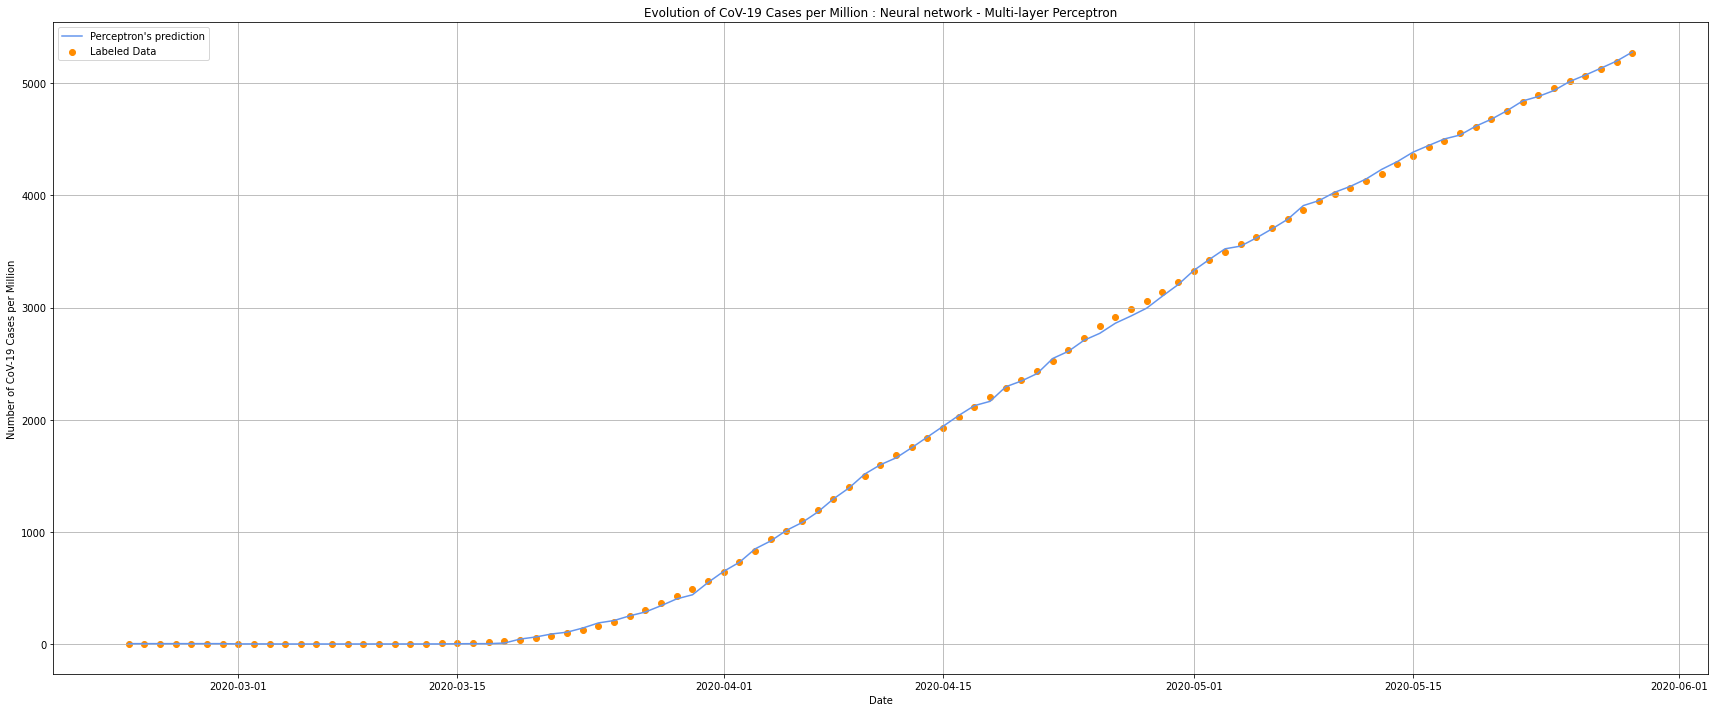

In [14]:
hidden_layer_neurons = (150,150,150)

# Fitting/Training Neural Network (MLP) Model
model = MLPRegressor(hidden_layer_neurons, validation_fraction = 0, solver='lbfgs').fit(X_train, Y_train)

# Obtaining predictions from models
X_pred = X[1746:,:]
Y_pred_label = Y[1746:,:]
print(X_pred.shape)
NN_predict = model.predict(X_pred)

# Testing models
NN_score = model.score(X_test, Y_test)
print('Score', NN_score)

# Evaluating the models
neural_network_eval = cross_val_score(model, X, Y, cv=10)
print("\nNeural Network CV:", np.mean(neural_network_eval))

# Visual Comparison of the predictions obtained by the NN model
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[0:97], Y_pred_label, color='darkorange', label='data')
NN_plot, = ax.plot(date_format[0:97], NN_predict, color='cornflowerblue')
ax.legend((NN_plot,labeled), ('Perceptron\'s prediction', 'Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title = "Evolution of CoV-19 Cases per Million : Neural network - Multi-layer Perceptron")
plt.tight_layout()
plt.show()

Although it requires a lot of computational power, it provides good and consistent results.

## Score Comparison
---

To better visualize the differences, in terms of scores, between the several algorithms we can look at the graph below.

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

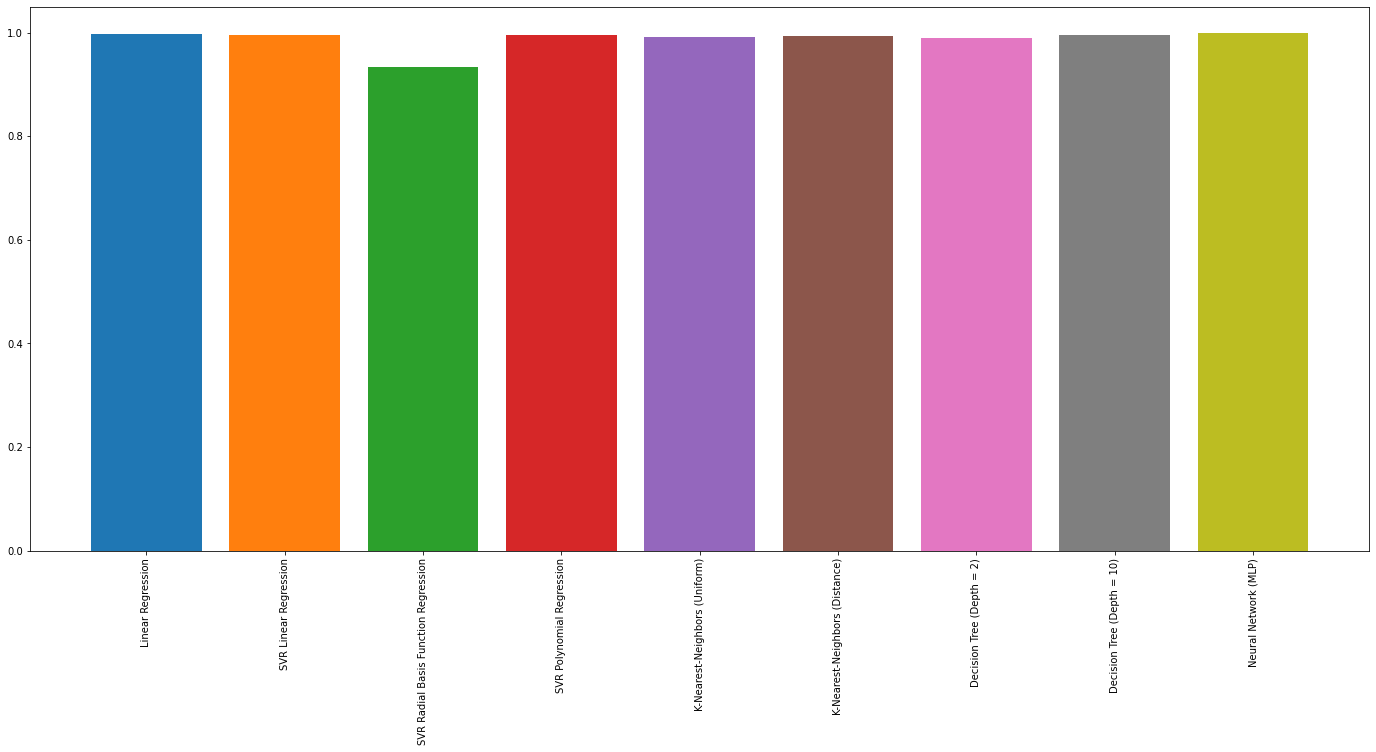

In [15]:
# Visual Comparison of the scores obtained by the different 
# models when predicting labeled data
_, ax = plt.subplots(figsize=(24, 10))
ax.bar('Linear Regression', linear_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Linear Regression', svr_lin_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Radial Basis Function Regression', svr_rbf_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Polynomial Regression', svr_poly_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('K-Nearest-Neighbors (Uniform)', knn_uniform_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('K-Nearest-Neighbors (Distance)', knn_distance_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('Decision Tree (Depth = 2)', dt_regressor_5_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('Decision Tree (Depth = 10)', dt_regressor_10_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('Neural Network (MLP)', NN_score, width=0.8, bottom=None, align='center', data=None)

plt.xticks(rotation=90)

### Principal Component Analysis

PCA is a statistical procedure that uses an orthogonal transformation to convert a set of variables, possibly correlated, into a set of values ​​of variables not linearly correlated, the main components. The PCA must be applied to the training set to obtain a new coordinate system defined only by the proper vectors, which are statistically significant.

In [16]:
pca = PCA(0.95)
principalComponents = pca.fit_transform(X) 
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents) 
print(pca.components_)

[0.52695139 0.21804284 0.08574569 0.03770935 0.0317162  0.02001957
 0.01883774 0.01365975]
[[-0.22705438 -0.17155543  0.25834322 -0.26500695 -0.26273942 -0.2553553
   0.15791346  0.15620307  0.1744258  -0.01939889  0.02695976 -0.01675665
   0.24668256 -0.22913987 -0.18633287  0.26155721 -0.26931231 -0.26689638
  -0.25879737  0.15318271  0.15113959  0.17371857  0.25080096  0.00683449]
 [ 0.08948724  0.21257465 -0.08534935  0.07292442  0.05866224  0.02906397
   0.29400374  0.30255723  0.21383759  0.31191134  0.32243211  0.33381656
  -0.07289314  0.0717909   0.19189409 -0.07158627  0.05706881  0.04562528
   0.02166508  0.29543244  0.30154599  0.21567982 -0.06182019  0.32672979]
 [ 0.03023318  0.02204866 -0.10504438  0.07228996  0.13956892  0.1083392
   0.21664636  0.29031138  0.21813498 -0.41248338 -0.33586724 -0.41274299
  -0.09356686 -0.01757755 -0.0070349  -0.07886548  0.04428932  0.11098192
   0.08353434  0.23150652  0.30144478  0.23390742 -0.08142281 -0.27680566]
 [ 0.14241524  0.521

Using this analysis, we obtain the principal components that make up for at least 75% of the variance ratio. These are the **Health System Index** and **Human Development Index**.

### Another Approach
---
Knowing that different countries apply different policies, have different lifestyles, and social and economical disparities, we believe it would be interesting to see if the model could correctly predict the evolution of the total number of cases per million of a given country using only data of similar countries in terms of GDP, HDI and Government Stringency, since these factors can directly affect the rate at which the virus propagates.

Having this in mind, Mexico, Argentina and South Africa seemed like good candidates, so the first two were used to predict the evolution of the third.

Score 0.9633940916786529


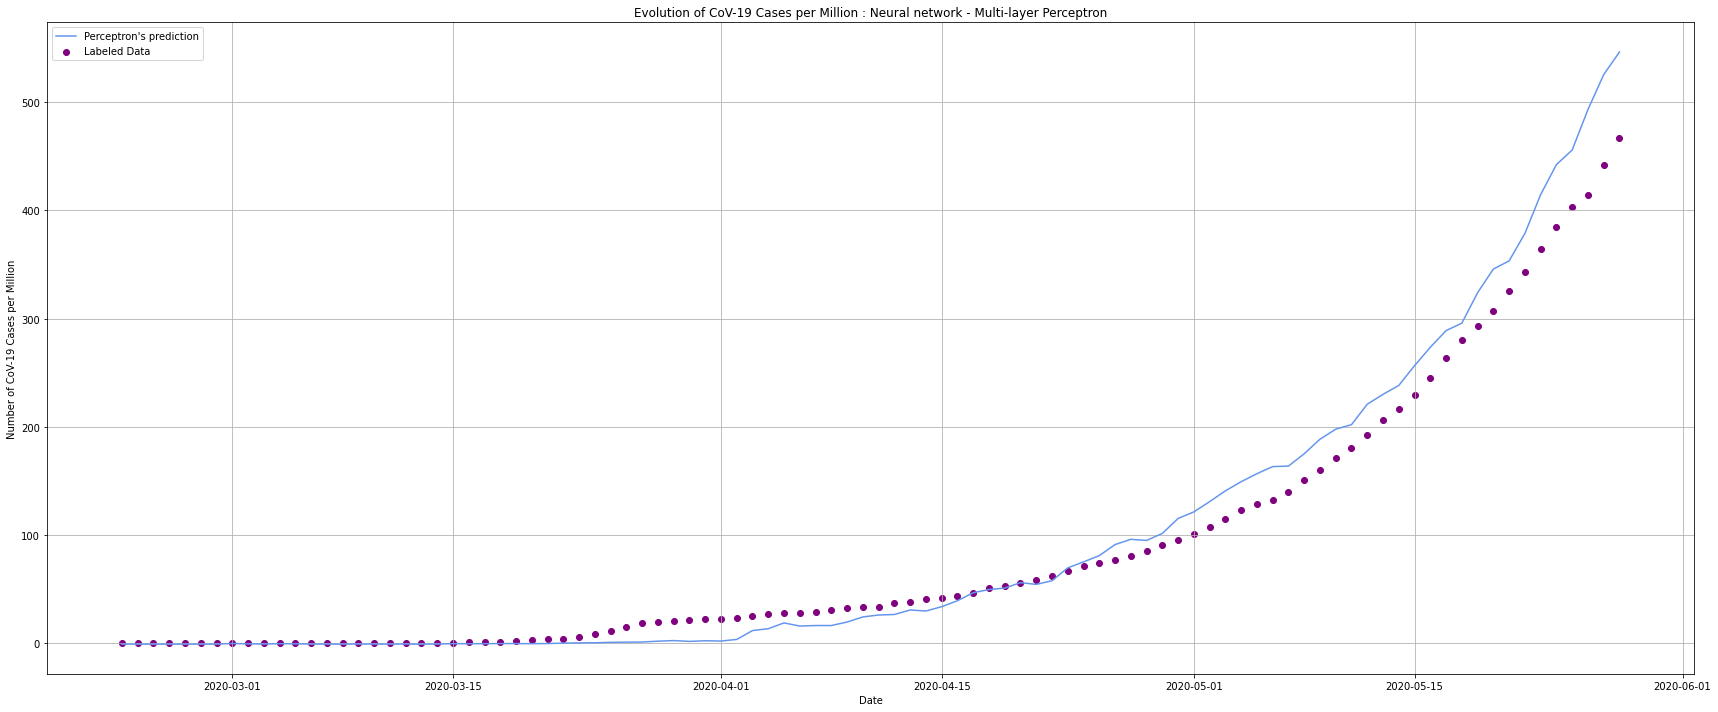

In [17]:
mexicoX = data.iloc[485:581,1:25]
mexicoY = data.iloc[485:581,25:26]

argentinaX = data.iloc[388:484, 1:25]
argentinaY = data.iloc[388:484, 25:26]

X = mexicoX.append(argentinaX)
Y = mexicoY.append(argentinaY)

safricaX = data.iloc[97:193, 1:25]
safricaY = data.iloc[97:193, 25:26]

# Fills the empty values taking mean values present in each column (Mean Inputation)
X = X.replace("", np.NaN)
Y = Y.replace("", np.NaN)
safricaX = safricaX.replace("", np.NaN)
safricaY = safricaY.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = imputer.fit_transform(X)
Y = imputer.fit_transform(Y)
safricaX =  imputer.fit_transform(safricaX)
safricaY =  imputer.fit_transform(safricaY)

# Standardization using Gaussian Normal Distribution
X = preprocessing.scale(X)
safricaX = preprocessing.scale(safricaX)

# Initalization of the Neural Network Model 
hidden_layers = (150,150,150)
model = MLPRegressor(hidden_layers, validation_fraction = 0, solver='lbfgs').fit(X, Y)

# Obtaining predictions from the model
NN_predict = model.predict(safricaX)

# Testing the model
NN_score = model.score(safricaX, safricaY)
print('Score', NN_score)

# Plot the results
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[0:96], safricaY, color='purple', label='data')

NN_plot, = ax.plot(date_format[0:96], NN_predict, color='cornflowerblue')
ax.legend((NN_plot,labeled), ('Perceptron\'s prediction', 'Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title = "Evolution of CoV-19 Cases per Million : Neural network - Multi-layer Perceptron")
plt.tight_layout()
plt.show()

As seen in the graph, the model correctly predicts most of the evolution of South Africa's CoV-19 cases.

### Confirmed Deaths
---

Since CoV-19 is more likely to cause the death of elderly people, we decided to pick countries with similar elderly population proportions, comparable GDP per capita and identical health system performances.

Such countries meeting this criteria were the United Kingdom, Italy, Spain, Canada and France. Using the first four countries we used the model to predict the number of confirmed deaths per million in France.

Score 0.9829962133191966


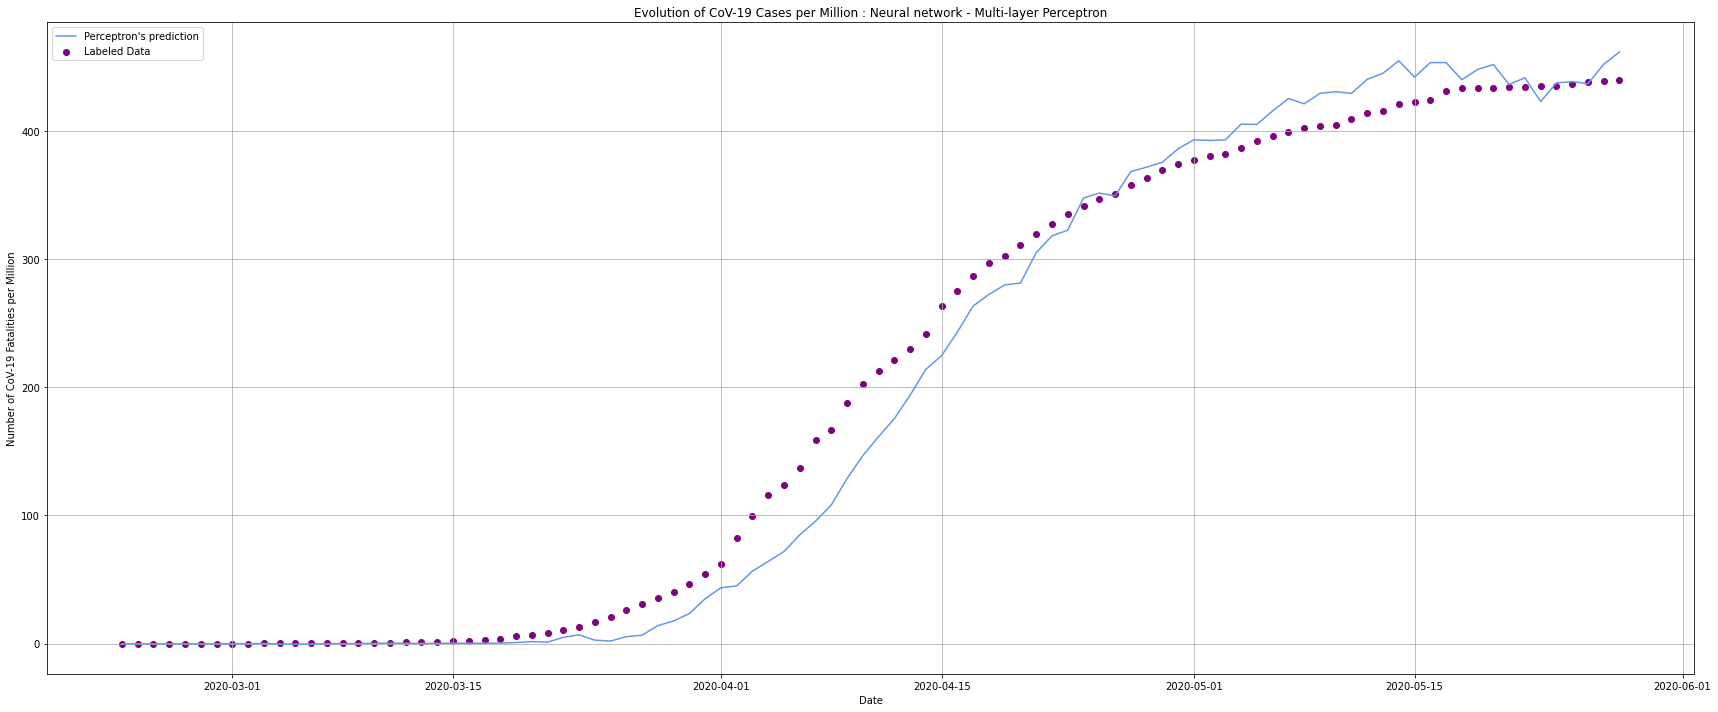

In [18]:
ukX = data.iloc[1067:1163,1:26]
ukY = data.iloc[1067:1163,26:]

germanyX = data.iloc[1455:1551, 1:26]
germanyY = data.iloc[1455:1551, 26:]

X = ukX.append(germanyX)
Y = ukY.append(germanyY)

italyX = data.iloc[679:775, 1:26]
italyY = data.iloc[679:775, 26:]

X = X.append(italyX)
Y = Y.append(italyY)

spainX = data.iloc[776:872, 1:26]
spainY = data.iloc[776:872, 26:]

X = X.append(spainX)
Y = Y.append(spainY)

canadaX = data.iloc[1261:1357, 1:26]
canadaY = data.iloc[1261:1357, 26:]

X = X.append(canadaX)
Y = Y.append(canadaY)

franceX = data.iloc[1164:1260, 1:26]
franceY = data.iloc[1164:1260, 26:]

# Fills the empty values taking mean values present in each column (Mean Inputation)
X = X.replace("", np.NaN)
Y = Y.replace("", np.NaN)
franceX = franceX.replace("", np.NaN)
franceY = franceY.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = imputer.fit_transform(X)
Y = imputer.fit_transform(Y)
franceX =  imputer.fit_transform(franceX)
franceY =  imputer.fit_transform(franceY)

# Standardization using Gaussian Normal Distribution
X = preprocessing.scale(X)
franceX = preprocessing.scale(franceX)

# Initalization of the Neural Network Model 
hidden_layers = (150,150,150)
model = MLPRegressor(hidden_layers, validation_fraction = 0, solver='lbfgs').fit(X, Y)

# Obtaining predictions from the model
NN_predict = model.predict(franceX)

# Testing the model
NN_score = model.score(franceX, franceY)
print('Score', NN_score)

# Plot the results
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[0:96], franceY, color='purple', label='data')

NN_plot, = ax.plot(date_format[0:96], NN_predict, color='cornflowerblue')
ax.legend((NN_plot,labeled), ('Perceptron\'s prediction', 'Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Fatalities per Million', title = "Evolution of CoV-19 Cases per Million : Neural network - Multi-layer Perceptron")
plt.tight_layout()
plt.show()

The graph above displays how the average number of confirmed deaths per million evolves and confirms the previous conclusions.

## Conclusion
This project helped us by introducing ourselves to Machine Learning, demystifying such a relevant branch of Artificial Intelligence.
We believe that given the circumstances, the subject of the project was crucial to demonstrate one of the many practical uses of this field making it more engaging.
Once the learning curve of both the programming language and the concepts of Machine Learning was passed, all of the algorithms were successfully implemented and delivered good results.

## References & Acknowledgements
    Google Community Mobility Reports and COVID Incidence. Dataset used with detailed information about it. Available at: https://www.kaggle.com/gustavomodelli/covid-community-measures​

    Supervised Learning Documentation. Official scikit-learn documentation about regression. Available at: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning​

    Different ways to compensate for missing values. Available at: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779​
    
    List of countries and dependencies by population. Available at: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population
    
    Coronavirus Map: Tracking the Global Outbreak. Available at: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html

    COVID-19 Community Mobility Report. Available at: https://www.google.com/covid19/mobility/

    MEASURING OVERALL HEALTH SYSTEM PERFORMANCE. Available at: https://www.who.int/healthinfo/paper30.pdf?ua=1

    COVID-19: Government Response Stringency Index. Available at: https://ourworldindata.org/grapher/covid-stringency-index

    List of countries by GDP (PPP). Available at: https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)

    List of countries by Human Development Index. Available at: https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index

    List of countries by age structure. Available at: https://en.wikipedia.org/wiki/List_of_countries_by_age_structure